# Study of Analogy based Learning - Image Classification


In this notebook, we perform the following task.
- Task 3: Visual Similarity Analysis by Projecting the Images on a 2D Space

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

from sklearn.metrics.pairwise import euclidean_distances

from sklearn.manifold import TSNE

from tensorflow import keras

## MNIST

We directly load the MNIST dataset using the Keras API:
https://keras.io/api/datasets/mnist/

The train set contains 60,000 images, and the test set contains 10,000 images.

In [2]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

# Scale the data
X_train = X_train/255.0
X_test = X_test/255.0


print("\nShape of Training Samples: ", X_train.shape)
print("Shape of Training Labels: ", y_train.shape)

print("\nShape of Testing Samples: ", X_test.shape)
print("Shape of Testing Labels: ", y_test.shape)


Shape of Training Samples:  (60000, 28, 28)
Shape of Training Labels:  (60000,)

Shape of Testing Samples:  (10000, 28, 28)
Shape of Testing Labels:  (10000,)


## MNIST Task 3: Visualization of the MNIST Dataset in 2D using t-SNE

We use the t-SNE (t-Distributed Stochastic Neighbor Embedding) algorithm to visualize the MNIST images in 2D.

The t-SNE is a Manifold Learning algorithm that reduces dimensionality while trying to keep similar instances close and dissimilar instances apart.

## Dimensionality Reduction using t-SNE

Dimensionality reduction using t-SNE on the full 60,000 images takes a very long time.

Thus, we use a random subset of 10,000 images for projecting it onto 2D.

In [3]:
m = 10000
idx = np.random.permutation(60000)[:m]

X = X_train[idx]
y = y_train[idx]

X = X.reshape(X.shape[0], 784)


print("\nReduced No. of Samples: ", X.shape)
print("Reduced No. of Labels: ", y.shape)


Reduced No. of Samples:  (10000, 784)
Reduced No. of Labels:  (10000,)


## Reduce Dimensionality to 2D

In [4]:
%%time

t0 = time.time()
tsne = TSNE(n_components=2, random_state=42)
X_tsne_reduced = tsne.fit_transform(X)
t1 = time.time()

duration_tsne = t1 - t0

print("The t-SNE takes {:.1f}s.".format(duration_tsne))
print("\n")

The t-SNE takes 178.7s.


CPU times: user 8min 18s, sys: 1min 24s, total: 9min 42s
Wall time: 2min 58s


## Plot the 2D Dataset
We use Matplotlib's scatter() function to plot a scatterplot, using a different color for each digit (0 = blue, 9 = dark red, etc.).

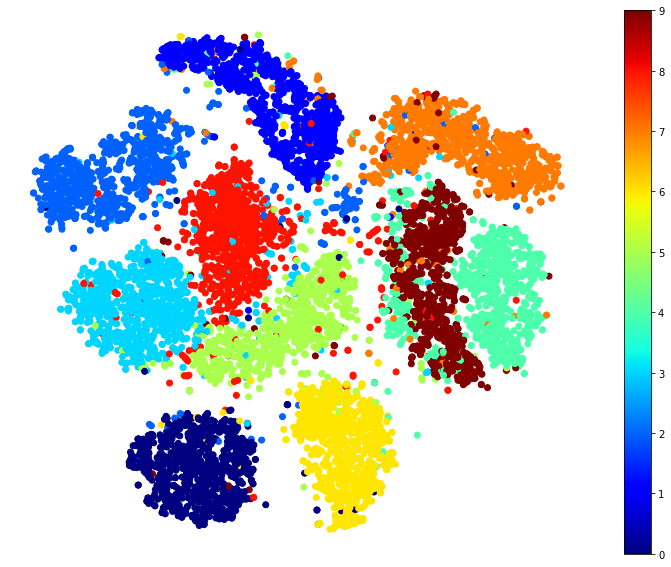

In [5]:
plt.figure(figsize=(13,10))
plt.scatter(X_tsne_reduced[:, 0], X_tsne_reduced[:, 1], c=y, cmap="jet")
plt.axis('off')
plt.colorbar()
plt.show()

## MNIST - Task 3 Observation:

This plot tells us that the numbers are genrally easily distinguishable from the others (e.g., 0s, 6s, and most 8s are rather well separated clusters). To further investigate this phenomenon, we plot the original images using a 2D scatter plot.


## Function to Display Colored Digits on a Scatterplot

We define a plot_digits() function that creates scatterplot using a different color for each digit and performs the followng two things.

- Write colored digits on the scatterplot, with a minimum distance guaranteed between these digits. 

- Plot digit images on the scatterplot. 

In [6]:
def plot_digits(X, y, min_distance=0.05, images=None, figsize=(13, 10)):
    # Let's scale the input features so that they range from 0 to 1
    X_normalized = MinMaxScaler().fit_transform(X)
    # Now we create the list of coordinates of the digits plotted so far.
    # We pretend that one is already plotted far away at the start, to
    # avoid `if` statements in the loop below
    neighbors = np.array([[10., 10.]])
    # The rest should be self-explanatory
    plt.figure(figsize=figsize)
    cmap = mpl.cm.get_cmap("jet")
    digits = np.unique(y)
    for digit in digits:
        plt.scatter(X_normalized[y == digit, 0], X_normalized[y == digit, 1], c=[cmap(digit / 9)])
    plt.axis("off")
    ax = plt.gcf().gca()  # get current axes in current figure
    for index, image_coord in enumerate(X_normalized):
        closest_distance = np.linalg.norm(np.array(neighbors) - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            if images is None:
                plt.text(image_coord[0], image_coord[1], str(int(y[index])),
                         color=cmap(y[index] / 9), fontdict={"weight": "bold", "size": 16})
            else:
                image = images[index].reshape(28, 28)
                imagebox = AnnotationBbox(OffsetImage(image, cmap="binary"), image_coord)
                ax.add_artist(imagebox)

## Plot Digit Images on the Scatterplot

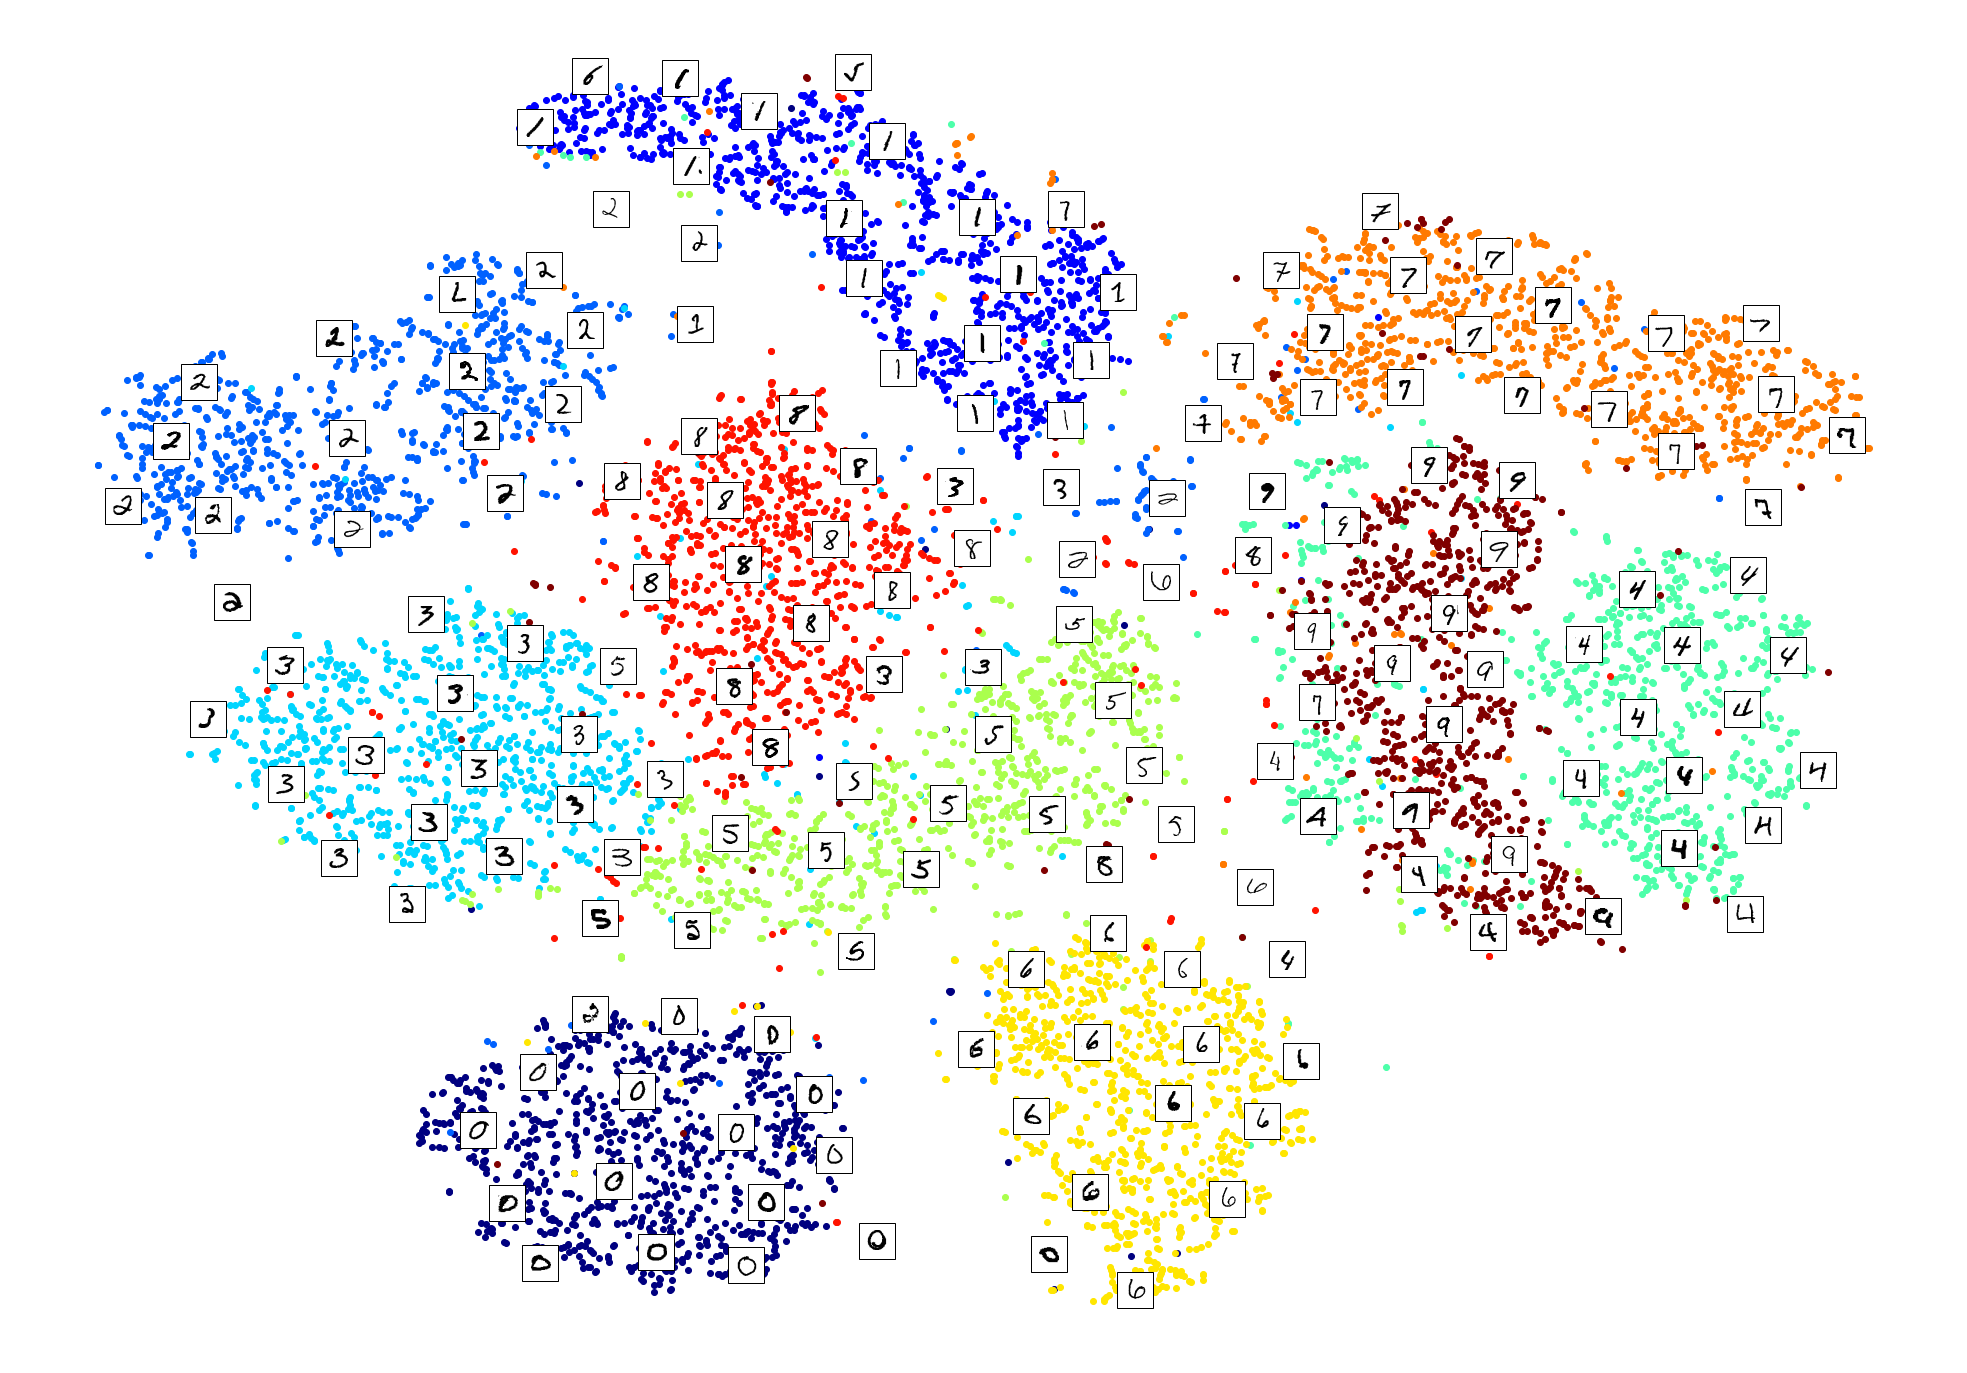

In [7]:
plot_digits(X_tsne_reduced, y, images=X, figsize=(35, 25))

## MNIST Task 3 - Observation

We observe that the generally the classes are distinguishable. The pixel-level similarity is good enough to determine the semantic identity of the images. This is due to the fact that MNIST images have a strong bias. This bias is manifested as follows. 

- Images are centered
- Less variation in the distribution of the pixels of the same class
- Share the same background


We will see that CIFAR-10 images don't have this bias. As a consequence, pixel level analogy will not lend useful to determine the semantic identity.

# CIFAR-10

We directly load the CIFAR-10 dataset using the Keras API:
https://keras.io/api/datasets/cifar10/

The train set contains 50,000 images, and the test set contains 10,000 images.

In [8]:
(X_train_cifar, y_train_cifar), (X_test_cifar, y_test_cifar) = keras.datasets.cifar10.load_data()

# Scale the data
X_train_cifar = X_train_cifar/255.0
X_test_cifar = X_test_cifar/255.0

print("\nShape of Training Samples: ", X_train_cifar.shape)
print("Shape of Training Labels: ", y_train_cifar.shape)

print("\nShape of Testing Samples: ", X_test_cifar.shape)
print("Shape of Testing Labels: ", y_test_cifar.shape)


Shape of Training Samples:  (50000, 32, 32, 3)
Shape of Training Labels:  (50000, 1)

Shape of Testing Samples:  (10000, 32, 32, 3)
Shape of Testing Labels:  (10000, 1)


## CIFAR-10: Create a List of Class Names

In [9]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

print(class_names)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## CIFAR-10 - Task 3: Visual Similarity Analysis by Projecting the Images on a 2D Space

We visually analyze the similarity of the images by projecting those on a 2D space. For this, we use the t-Distributed Stochastic Neighbor Embedding (t-SNE) technique of dimensionality reduction. It projects the data into a lower dimension by maintaining their pair-wise local distance. Thus, if two images are "close" or "similar" in high-dimension, they will be spatially closer in 2D, which we will be able to visually inspect.

## Dimensionality Reduction using t-SNE

Dimensionality reduction using t-SNE on the full 50,000 images takes a very long time. Thus, we use a random subset of 10,000 images for projecting it onto 2D.

In [10]:
m = 10000
idx = np.random.permutation(50000)[:m]

X_cifar = X_train_cifar[idx]
y_cifar = y_train_cifar[idx]

X_cifar = X_cifar.reshape(X_cifar.shape[0], 3072)

y_cifar = y_cifar.ravel()

print("\nReduced No. of Samples: ", X_cifar.shape)
print("Reduced No. of Labels: ", y_cifar.shape)


Reduced No. of Samples:  (10000, 3072)
Reduced No. of Labels:  (10000,)


## Reduce Dimensionality to 2D

In [11]:
%%time

t0 = time.time()
tsne_cifar  = TSNE(n_components=2, random_state=42)
X_tsne_reduced_cifar  = tsne_cifar.fit_transform(X_cifar)
t1 = time.time()

duration_tsne = t1 - t0

print("The t-SNE takes {:.1f}s.".format(duration_tsne))
print("\n")

The t-SNE takes 571.8s.


CPU times: user 15min 58s, sys: 1min 31s, total: 17min 30s
Wall time: 9min 31s


## Plot the 2D Dataset
We use Matplotlib's scatter() function to plot a scatterplot, using a different color for each digit (0 = blue, 9 = dark red, etc.).

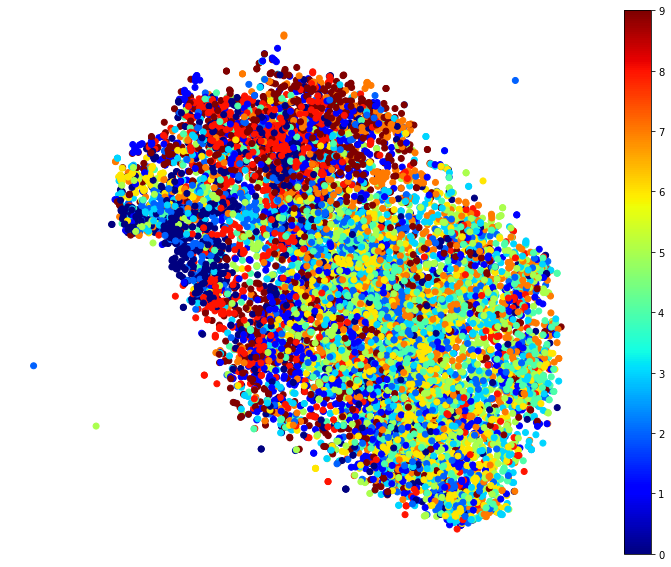

In [12]:
plt.figure(figsize=(13,10))
plt.scatter(X_tsne_reduced_cifar[:, 0], X_tsne_reduced_cifar[:, 1], c=y_cifar, cmap="jet")
plt.axis('off')
plt.colorbar()
plt.show()

## CIFAR-10 - Task 3 Observation:

This plot tells us that the classes are visually indistinguishable in 2D. There is no significant difference between intra-class and inter-class distance. To further investigate this phenomenon, we plot the original images using a 2D scatter plot.

## Function to Display Objects on a Scatterplot

We define a plot_objects() function that creates scatterplot using a different color for each digit and performs the followng two things.

- Write colored objects on the scatterplot, with a minimum distance guaranteed between these objects.

- Plot object images on the scatterplot.

In [13]:
def plot_objects(X, y, min_distance=0.05, images=None, figsize=(16, 12)):
    # Let's scale the input features so that they range from 0 to 1
    X_normalized = MinMaxScaler().fit_transform(X)
    # Now we create the list of coordinates of the digits plotted so far.
    # We pretend that one is already plotted far away at the start, to
    # avoid `if` statements in the loop below
    neighbors = np.array([[10., 10.]])
    # The rest should be self-explanatory
    plt.figure(figsize=figsize)
    cmap = mpl.cm.get_cmap("jet")
    objects = np.unique(y)
    for object in objects:
        plt.scatter(X_normalized[y == object, 0], X_normalized[y == object, 1], c=[cmap(object / 9)])
    plt.axis("off")
    ax = plt.gcf().gca()  # get current axes in current figure
    for index, image_coord in enumerate(X_normalized):
        closest_distance = np.linalg.norm(np.array(neighbors) - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            if images is None:
                plt.text(image_coord[0], image_coord[1], str(int(y[index])),
                         color=cmap(y[index] / 9), fontdict={"weight": "bold", "size": 16})
            else:
                image = images[index].reshape(32, 32, 3)
                imagebox = AnnotationBbox(OffsetImage(image, cmap="binary"), image_coord)
                ax.add_artist(imagebox)

## Plot Object Images on the Scatterplot

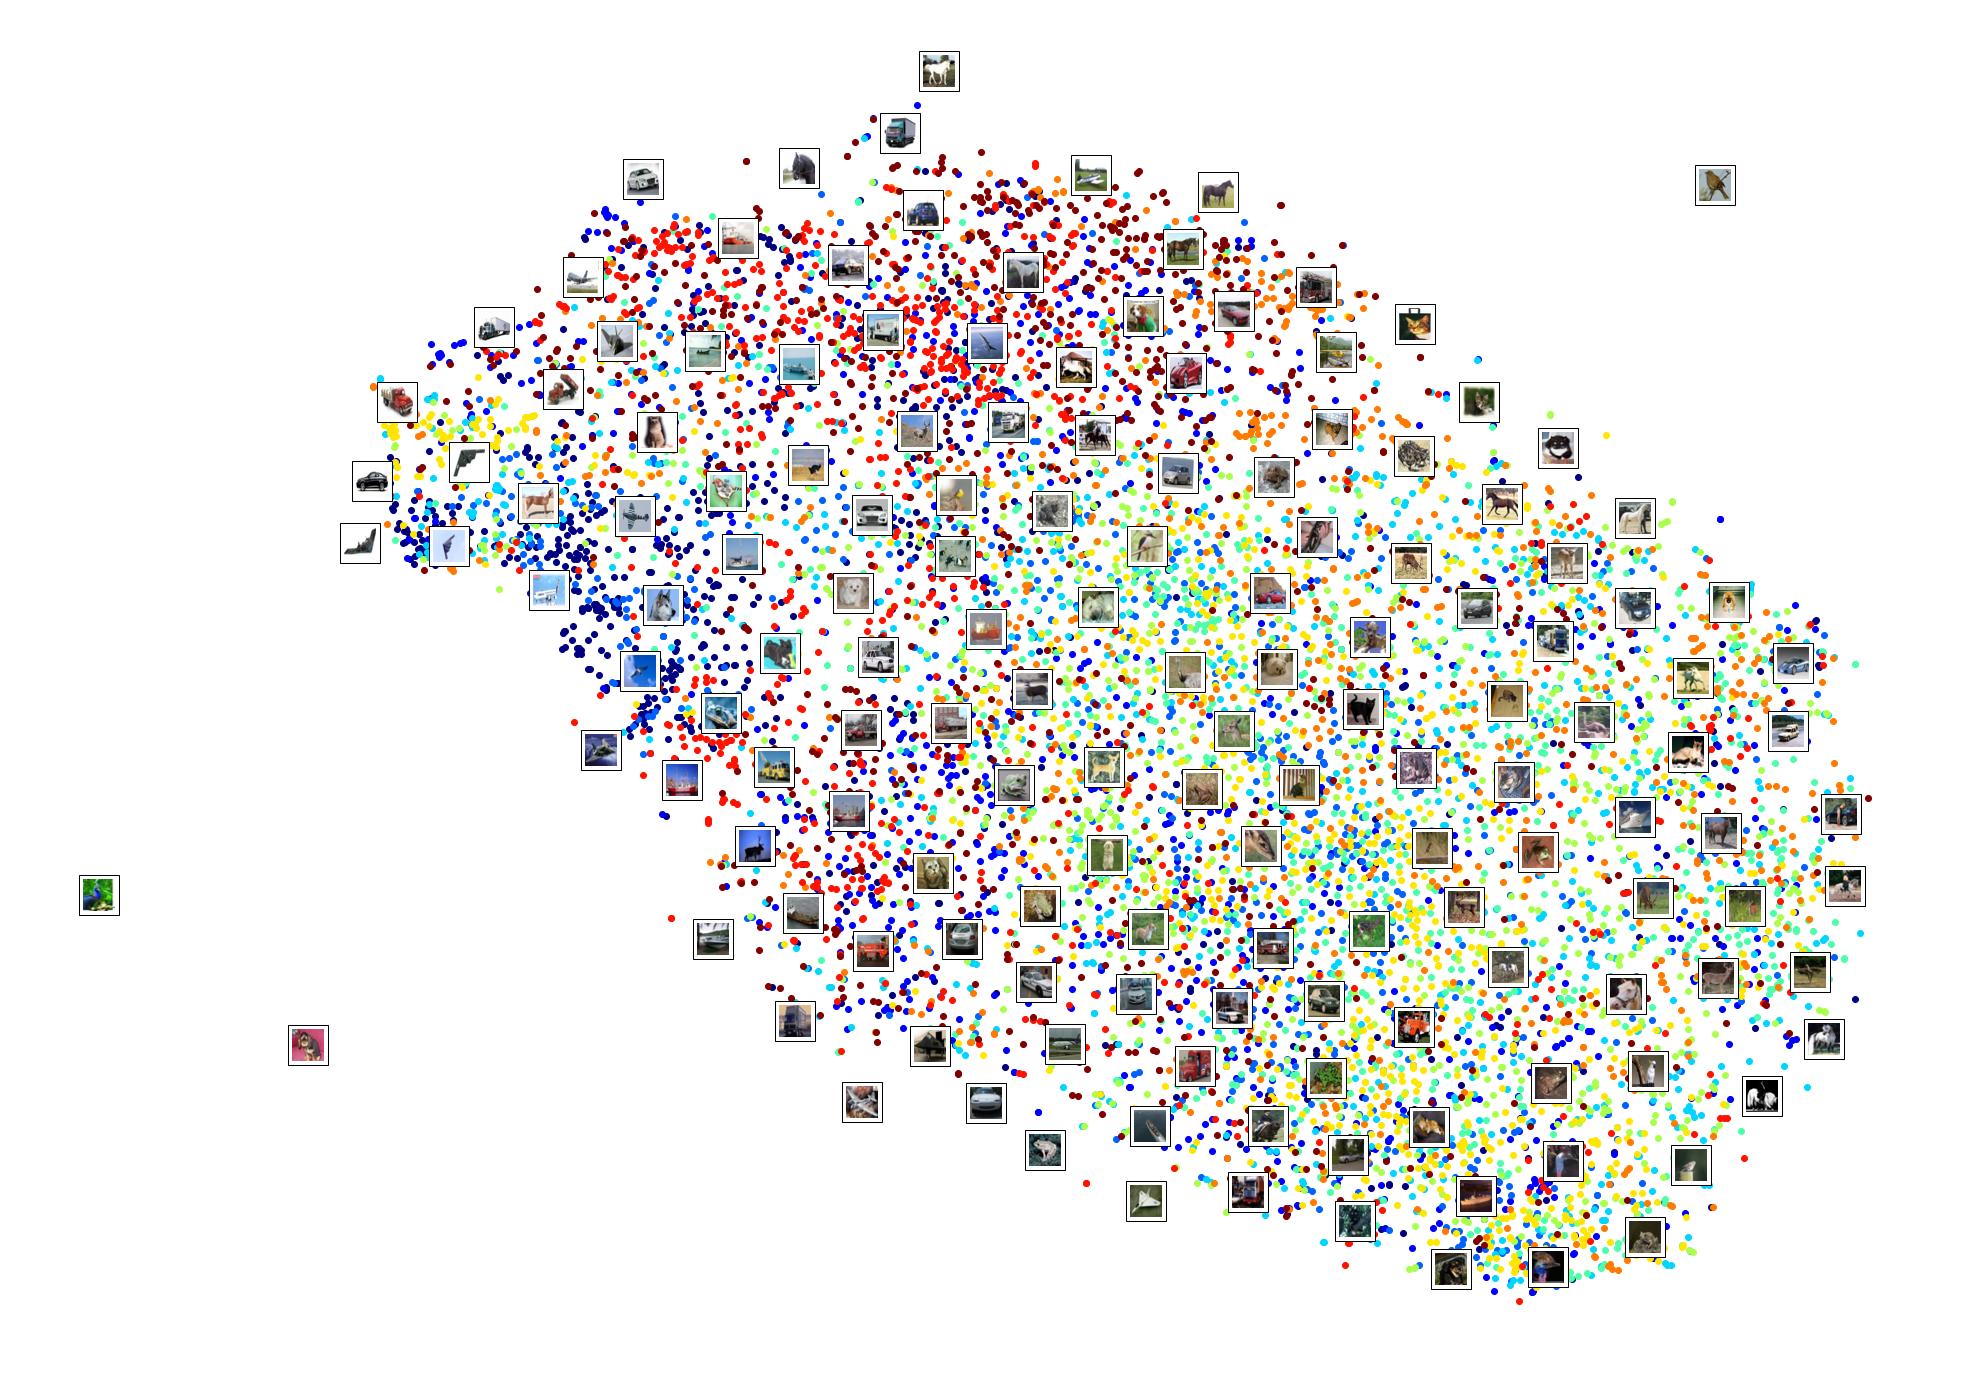

In [14]:
plot_objects(X_tsne_reduced_cifar, y_cifar, images=X_cifar, figsize=(35, 25))

## CIFAR-10 Task 3 - Observation

We observe that the classes are indistinguishable. The t-SNE algorithm relies on a distance-based metric to compute pair-wise similarity of the images at the pixel level. As a consequence, as argued earlier, there is no significant difference between intra-class and inter-class distance.

Notice that there is a **strong effect of background** on similarity computation. Images are spatially close/similar due to their color distribution and type of their background. The similarity is not determined by their semantic label. Two different objects such as a bird and an airplane are "similar" because they share the same background. On the other hand, two objects belonging to the same class could be far away due the variation in their background.


# Beyond Raw Pixel Based Similarity: Is Analogy based Learning Effective for Image Classification?

The distance metric does not provide a reliable measure, when applied at the pixel level, to determine semantic identity of an image. It doesn't mean that the distance based technique or analogy based reasoning in general is flawed/weak. The similarity based approach is effective when more expressive and powerful high-level features are extracted from raw pixels. In other words, while distance measures at the raw pixel level produce spurious results, similarity calculation on the high-level fetures reveal semantic identity.

The following papers achieve state-of-the-art results on image classification by applying the K-NN analogy based approach on the learned features.

- Xu et al. (2020) Hierarchical Semantic Aggregation for Contrastive Representation Learning https://arxiv.org/pdf/2012.02733v1.pdf

- Caron et el. (2021) Unsupervised Learning of Visual Features by Contrasting Cluster Assignments
https://arxiv.org/pdf/2006.09882.pdf


